## Student Name:    Jiayuan Zhu

## Student ID:     1067734

**Term of use:**
1. Le, Q. V., & Mikolov, T. (2014). ​Distributed Representations of Sentences and Documents.​
2. Mukherjee, A., Venkataraman, V., Liu B. & Glance N.S. (2013). ​What Yelp fake review filter might be doing?​ ICWSM.
3. Rayana S. & Akoglu L. (2015). ​Collective Opinion Spam Detection: Bridging Review Networks and Metadata​. Sydney, Australia: ACM SIGKDD.

In [2]:
import pandas as pd
import numpy as np
import string
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.dummy import DummyClassifier

In [3]:
# Read the CSV files
meta = pd.read_csv('review_meta_train.csv')
docvec50 = pd.read_csv('review_text_train_doc2vec50.csv', header = None)
docvec100 = pd.read_csv('review_text_train_doc2vec100.csv', header = None)
docvec200 = pd.read_csv('review_text_train_doc2vec200.csv', header = None)
meta_test = pd.read_csv('review_meta_test.csv')
docvec50_test = pd.read_csv('review_text_test_doc2vec50.csv', header = None)
docvec100_test = pd.read_csv('review_text_test_doc2vec100.csv', header = None)
docvec200_test = pd.read_csv('review_text_test_doc2vec200.csv', header = None)
text = pd.read_csv('review_text_train.csv')
label = meta.iloc[:, 7]

## TF-IDF

In [4]:
# Convert text format for TF-IDF
for i in string.punctuation:
    text['review'] = text[['review']].applymap(lambda x: x.replace(i, " "))
useful_df = pd.concat([meta.iloc[:, 4:7], text], axis = 1)
# Split training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(useful_df, label, test_size = 0.33, random_state = 42)
# Apply TF-IDF for both training and testing
vectorize = TfidfVectorizer()
x_train_transform = vectorize.fit_transform(x_train['review'])
x_test_transform = vectorize.transform(x_test['review'])
x_train_transform_df = pd.DataFrame(x_train_transform.toarray(), columns = vectorize.get_feature_names(), 
                                    index = x_train.index)
x_test_transform_df = pd.DataFrame(x_test_transform.toarray(), columns = vectorize.get_feature_names(), 
                                   index = x_test.index)

In [5]:
simplefilter("ignore", category = ConvergenceWarning)
roc_acu_list_tfidf = []
acc_list_tfidf = []
for k_best in [50, 100, 200]:
    # Run several times to reduce variances 
    for runs in range(3):
        temp_roc = []
        temp_acc = []
        
        # Split the whole training dataset into another training and validation dataset
        x_train_useful, x_valid, y_train_useful, y_valid = train_test_split(
            x_train_transform, y_train, test_size = 0.33, random_state = 100 * runs)  
        
        # Use mutual information to find the best k features then convert
        # Training and validation set to corrsbonding demension
        mi = SelectKBest(score_func = mutual_info_classif, k = k_best)
        x_train_useful = mi.fit_transform(x_train_useful, y_train_useful)
        x_valid = mi.transform(x_valid)
            
        # Shuffle dataset in preparation for cross validation
        x_train_useful, y_train_useful = shuffle(x_train_useful, y_train_useful, random_state = 42)
            
        # Train the training dataset with the specific model then predict on the validation set
        model = LogisticRegression()
        model.fit(x_train_useful, y_train_useful)
        y_score = model.predict_proba(x_valid)
        y_valid_binarize = label_binarize(y_valid, classes = [1, 3, 5])

        # Calcuate roc_auc_score and accuracy score
        temp_roc.append(roc_auc_score(y_valid_binarize, y_score))
        temp_acc.append(model.score(x_valid, y_valid))
      
    # Append average roc_auc_score and accuracy score for this k
    roc_acu_list_tfidf.append(sum(temp_roc)/ len(temp_roc))
    acc_list_tfidf.append(sum(temp_acc) / len(temp_acc))

In [6]:
roc_acu_list_doc2vec = []
acc_list_doc2vec = []
for file in [docvec50, docvec100, docvec200]:
    # Split training and testing dataset
    x_train, x_test, y_train, y_test = train_test_split(file, label, test_size = 0.33, random_state = 42)
    
    # Run several times to reduce variances 
    for runs in range(3):
        temp_roc = []
        temp_acc = []

        # Split the whole training dataset into another training and validation dataset
        x_train_useful, x_valid, y_train_useful, y_valid = train_test_split(
            x_train, y_train, test_size = 0.33, random_state = 100*runs)
            
        # Shuffle dataset in preparation for cross validation
        x_train_useful, y_train_useful = shuffle(x_train_useful, y_train_useful, random_state = 42)
            
        # Train the training dataset with the specific model then predict
        # the validation set
        model = LogisticRegression()
        model.fit(x_train_useful, y_train_useful)
        y_score = model.predict_proba(x_valid)
        y_valid_binarize = label_binarize(y_valid, classes = [1, 3, 5])

        # Calcuate roc_auc_score and accuracy score
        temp_roc.append(roc_auc_score(y_valid_binarize, y_score))
        temp_acc.append(model.score(x_valid, y_valid))
      
    # Append average roc_auc_score and accuracy score 
    roc_acu_list_doc2vec.append(sum(temp_roc) / len(temp_roc))
    acc_list_doc2vec.append(sum(temp_acc) / len(temp_acc))


Text(0, 0.5, 'Test Score')

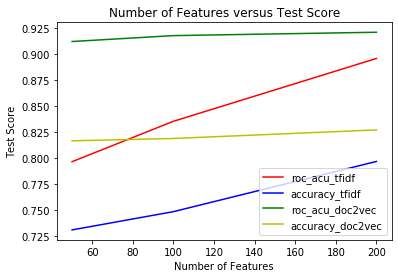

In [7]:
# Plot the graph 
plt.plot([50,100,200], roc_acu_list_tfidf, color = 'r', label = 'roc_acu_tfidf')
plt.plot([50,100,200], acc_list_tfidf, color = 'b', label = 'accuracy_tfidf')
plt.plot([50,100,200], roc_acu_list_doc2vec, color = 'g', label = 'roc_acu_doc2vec')
plt.plot([50,100,200], acc_list_doc2vec, color = 'y', label = 'accuracy_doc2vec')
plt.legend()
plt.title(f'Number of Features versus Test Score')
plt.xlabel('Number of Features')
plt.ylabel('Test Score')

In [8]:
# Split the whole dataset to training and testing dataset then counstruct 0-R benchmark
x_train, x_test, y_train, y_test = train_test_split(meta, label, test_size = 0.33, random_state = 42)
dummy_model = DummyClassifier(strategy = "most_frequent")
dummy_model.fit(x_train, y_train)
dummy_model.score(x_test, y_test)

0.6924322573680233

In [9]:
# Find the auc_roc value and accuracy value for different number 
# of best k features then plot the graph
def choose_csv(docvecfile, model_type, docvec_name, model_name, color1, color2):

    # Combine features and split into training and testing dataset
    useful_df = pd.concat([meta.iloc[:, 4:7], docvecfile], axis = 1)

    # Splitting training and testing dataset and intialize values
    x_train, x_test, y_train, y_test = train_test_split(useful_df, label, test_size = 0.33, random_state = 42)
    roc_acu_list = []
    acc_list  = []
    k_best = 0
    interval = int(useful_df.shape[1] / 10)
    
    # Select different number of features
    while k_best < useful_df.shape[1]:
        k_best += interval
        k_best = min(k_best, useful_df.shape[1])

        # Run several times to reduce variances 
        for runs in range(3):
            temp_roc = []
            temp_acc = []

            # Split the whole training dataset into another training and validation dataset
            x_train_useful, x_valid, y_train_useful, y_valid = train_test_split(
                x_train, y_train, test_size = 0.33, random_state = 100*runs)
          
            # Use mutual information to find the best k features then convert
            # Training and validation set to corrsbonding demension
            mi = SelectKBest(score_func = mutual_info_classif, k = k_best)
            x_train_useful = mi.fit_transform(x_train_useful, y_train_useful)
            x_valid = mi.transform(x_valid)
            
            # Shuffle dataset in preparation for cross validation
            x_train_useful, y_train_useful = shuffle(x_train_useful, y_train_useful, random_state = 42)

            # Train the training dataset with the specific model then predict
            # the validation set
            model = model_type
            model.fit(x_train_useful, y_train_useful)
            y_score = model.predict_proba(x_valid)
            y_valid_binarize = label_binarize(y_valid, classes = [1, 3, 5])

            # Calcuate roc_auc_score and accuracy score
            temp_roc.append(roc_auc_score(y_valid_binarize, y_score))
            temp_acc.append(model.score(x_valid, y_valid))
      
        # Append average roc_auc_score and accuracy score for this k
        roc_acu_list.append(sum(temp_roc)/ len(temp_roc))
        acc_list.append(sum(temp_acc) / len(temp_acc))

    # Plot the graph 
    plt.plot(range(interval, interval*11 + 1, interval), roc_acu_list, color = color1, 
             label = 'roc_acu_'+docvec_name)
    plt.plot(range(interval, interval*11 + 1, interval), acc_list, color = color2, 
             label = 'accuracy_'+docvec_name)
    plt.legend()
    plt.title(f'Number of Best Features versus Test Score of {model_name}')
    plt.xlabel('Number of Best Features')
    plt.ylabel('Test Score')

    return roc_acu_list, acc_list

In [10]:
# Find the number of best k features and corrsponding dataset to use
def suitable_dataset(file1_result, file2_result, file3_result, file1, file2, file3):

    # Find the max score for roc_acu and accuracy
    roc_acu_list_max = max(max(file1_result[0]), max(file2_result[0]), max(file3_result[0]))
    acc_list_max = max(max(file1_result[1]), max(file2_result[1]), max(file3_result[1]))
    target_list = [roc_acu_list_max, acc_list_max]
    dataset_use = []

    # Find the number of best k features and corresponding dataset 
    # by comparing to the max scores achieved
    for i in range(2):
        for j in range(11):
            if target_list[i] == file1_result[i][j]:
                dataset_use.append([docvec50, min(5*(j+1), file1.shape[1]+3)])
            if target_list[i] == file2_result[i][j]:
                dataset_use.append([docvec100, min(10*(j+1), file2.shape[1]+3)])
            if target_list[i] == file3_result[i][j]:
                dataset_use.append([docvec200, min(20*(j+1), file3.shape[1]+3)])
    return dataset_use

## Random Forest Classifier

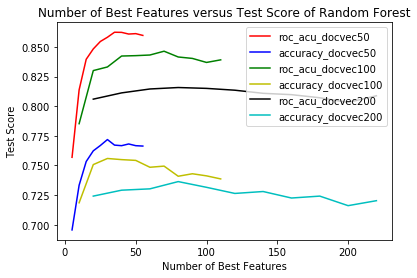

In [11]:
# Find the auc_roc value and accuracy value for different number 
# of best k features then plot the graph
choose_docvec50_rf = choose_csv(docvec50, RandomForestClassifier(), 
                                'docvec50', 'Random Forest', 'r', 'b')
choose_docvec100_rf = choose_csv(docvec100, RandomForestClassifier(), 
                                 'docvec100', 'Random Forest','g', 'y')
choose_docvec200_rf = choose_csv(docvec200, RandomForestClassifier(), 
                                 'docvec200', 'Random Forest','k', 'c')

In [12]:
# Find the number of best k features and corrsponding dataset to use
dataset_rf = suitable_dataset(choose_docvec50_rf, choose_docvec100_rf, choose_docvec200_rf, 
                              docvec50, docvec100, docvec200)

# Create the new dataset according to the dataset selected
useful_df = pd.concat([meta.iloc[:, 4:7], dataset_rf[0][0]], axis = 1)
real_test_rf = pd.concat([meta_test.iloc[:, 4:7], docvec50_test], axis = 1)

# Split the whole dataset to training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(useful_df, label, test_size=0.33, random_state = 42)

# Convert the training and testing dataset to the desired demension
# by the number of best k features 
mi = SelectKBest(score_func = mutual_info_classif, k = dataset_rf[0][1])
x_train = pd.DataFrame(mi.fit_transform(x_train, y_train))
x_test = pd.DataFrame(mi.transform(x_test))
real_test_rf = pd.DataFrame(mi.transform(real_test_rf))

# Shuffle dataset in preparation for cross validation
x_train, y_train = shuffle(x_train, y_train, random_state = 42)

# Binarize training dataset's label in prepartion of scoring by roc_auc
y_train_binarize = label_binarize(y_train, classes = [1, 3, 5])

Text(0, 0.5, 'Test Score')

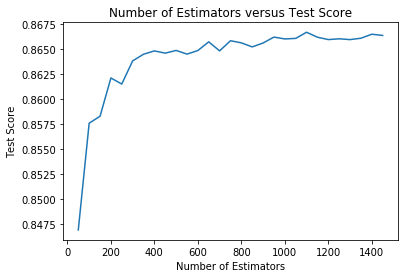

In [13]:
# Cursory search for number of estimators hyperparameter
n_estimators_score = []
for i in range(50, 1500, 50):
    cv_results = cross_validate(RandomForestClassifier(n_estimators = i), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    n_estimators_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph
plt.plot(range(50, 1500, 50), n_estimators_score)
plt.title(f'Number of Estimators versus Test Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

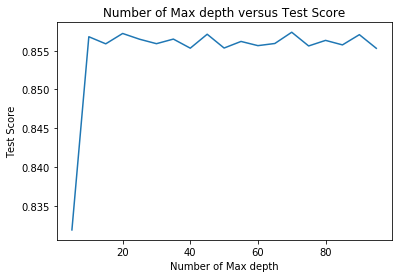

In [14]:
# Cursory search for number of max depth hyperparameter
n_max_depth_score = []
for i in range(5, 100, 5):
    cv_results = cross_validate(RandomForestClassifier(max_depth = i), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    n_max_depth_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph
plt.plot(range(5, 100, 5), n_max_depth_score)
plt.title(f'Number of Max depth versus Test Score')
plt.xlabel('Number of Max depth')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

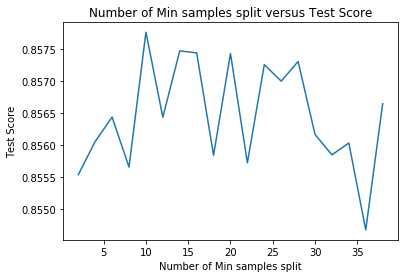

In [15]:
# Cursory search for number of min split hyperparameter
n_min_split_score = []
for i in range(2, 40, 2):
    cv_results = cross_validate(RandomForestClassifier(min_samples_split = i), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    n_min_split_score.append(sum(cv_results['test_score']) / len(cv_results))

# Plot the graph    
plt.plot(range(2, 40, 2), n_min_split_score)
plt.title(f'Number of Min samples split versus Test Score')
plt.xlabel('Number of Min samples split')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

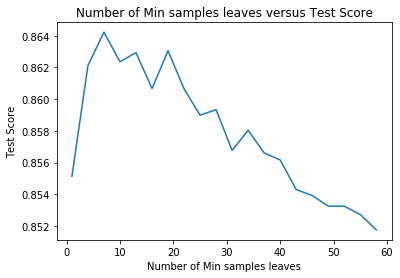

In [16]:
# Cursory search for number of min leaves hyperparameter
n_min_leaves_score = []
for i in range(1, 60, 3):
    cv_results = cross_validate(RandomForestClassifier(min_samples_leaf = i), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    n_min_leaves_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph    
plt.plot(range(1, 60, 3), n_min_leaves_score)
plt.title(f'Number of Min samples leaves versus Test Score')
plt.xlabel('Number of Min samples leaves')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

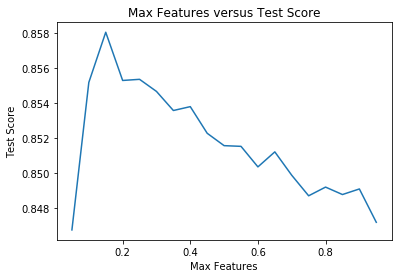

In [17]:
# Cursory search for max features hyperparameter
max_features_score = []
for i in np.arange(0.05, 1, 0.05):
    cv_results = cross_validate(RandomForestClassifier(max_features = i), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    max_features_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph    
plt.plot(np.arange(0.05, 1, 0.05), max_features_score)
plt.title(f'Max Features versus Test Score')
plt.xlabel('Max Features')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

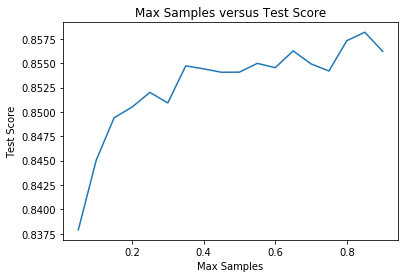

In [18]:
# Cursory search for max sample hyperparameter
max_samples_score = []
for i in np.arange(0.05, 0.95, 0.05):
    cv_results = cross_validate(RandomForestClassifier(max_samples = i), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    max_samples_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph    
plt.plot(np.arange(0.05, 0.95, 0.05), max_samples_score)
plt.title(f'Max Samples versus Test Score')
plt.xlabel('Max Samples')
plt.ylabel('Test Score')

In [19]:
# Construct the function that needs to be maximize Random Forest Classifier
# Here the aim is to maximize the roc_auc score
def randomforest_func(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, max_samples):
    cv_results = cross_validate(RandomForestClassifier(n_estimators = int(round(n_estimators)),
                            max_depth = int(round(max_depth)), min_samples_split = int(round(min_samples_split)),
                            min_samples_leaf = int(round(min_samples_leaf)),
                            max_features = max_features, 
                            max_samples = max_samples),
                            x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    return sum(cv_results['test_score']) / len(cv_results)

In [20]:
# Find the global maximum of the target function 
randomforest_params = BayesianOptimization(randomforest_func, {'n_estimators': (600,1000), 'max_depth': (15, 60), 
                                        'min_samples_split': (6, 22), 'min_samples_leaf':(6, 15), 
                                        'max_features': (0.05, 0.6), 'max_samples':(0.2,0.999)}, random_state = 42)
randomforest_params.maximize(n_iter = 20, init_points = 2)

|   iter    |  target   | max_depth | max_fe... | max_sa... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
|  1        |  0.8584   |  31.85    |  0.5729   |  0.7849   |  11.39    |  8.496    |  662.4    |
|  2        |  0.8587   |  17.61    |  0.5264   |  0.6803   |  12.37    |  6.329    |  988.0    |
|  3        |  0.8646   |  59.55    |  0.1643   |  0.6353   |  14.89    |  18.67    |  997.3    |
|  4        |  0.8658   |  56.81    |  0.1195   |  0.5576   |  10.85    |  19.46    |  997.5    |
|  5        |  0.8646   |  57.3     |  0.3492   |  0.7086   |  6.249    |  6.673    |  984.9    |
|  6        |  0.858    |  59.0     |  0.5984   |  0.6749   |  7.421    |  21.83    |  996.2    |
|  7        |  0.8611   |  57.08    |  0.2849   |  0.5853   |  14.97    |  6.356    |  850.4    |
|  8        |  0.8638   |  59.98    |  0.06571  |  0.8263   |  14.96    |  6.599    |  603.0    |
|  9        |  0.866

In [21]:
# Find the best parameter
final_para_rf = randomforest_params.max

# Construct the Random Forest Classifier model
randomforest_model = RandomForestClassifier(n_estimators = int(round(final_para_rf['params']['n_estimators'])),
                              max_depth = int(round(final_para_rf['params']['max_depth'])), 
                              min_samples_split = int(round(final_para_rf['params']['min_samples_split'])),
                              min_samples_leaf = int(round(final_para_rf['params']['min_samples_leaf'])),
                              max_features = final_para_rf['params']['max_features'], 
                              max_samples = final_para_rf['params']['max_samples'])

# Train the model according to the training dataset
randomforest_model.fit(x_train, y_train)

# Predict and analysis the model 
model_pred = randomforest_model.predict(x_test)
report_analysis = classification_report(y_test, model_pred, 
                                        target_names = ['Rating = 1', 'Rating = 3', 'Rating = 5'])
print(report_analysis)
print(f'Exact accuracy for Random Forest is {randomforest_model.score(x_test, y_test)}')

              precision    recall  f1-score   support

  Rating = 1       0.79      0.21      0.34       789
  Rating = 3       0.66      0.33      0.43      2060
  Rating = 5       0.78      0.98      0.87      6414

    accuracy                           0.77      9263
   macro avg       0.74      0.51      0.55      9263
weighted avg       0.75      0.77      0.73      9263

Exact accuracy for Random Forest is 0.7681096836877901


In [22]:
# Predict ratings for real testing set and convert to csv
model_pred_rf = randomforest_model.predict(real_test_rf)
Instance_id = list(range(1, len(model_pred_rf)+1))
randomforest_pred = pd.DataFrame(data = {'Instance_id': Instance_id, 'rating': model_pred_rf})
randomforest_pred = randomforest_pred.set_index(['Instance_id', 'rating'])
randomforest_pred.to_csv('Random Forest Classifier.csv')

## Logistic Regression

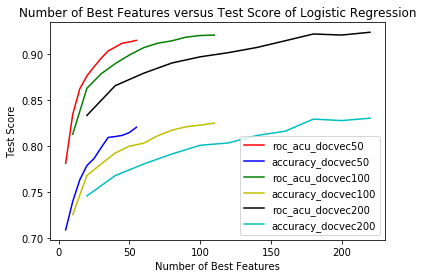

In [23]:
# Find the auc_roc value and accuracy value for different number 
# of best k features then plot the graph in Logistic Regression
choose_docvec50_lr = choose_csv(docvec50, LogisticRegression(max_iter = 1000), 'docvec50', 
                                'Logistic Regression', 'r', 'b')
choose_docvec100_lr = choose_csv(docvec100, LogisticRegression(max_iter = 1000), 'docvec100', 
                                 'Logistic Regression','g', 'y')
choose_docvec200_lr = choose_csv(docvec200, LogisticRegression(max_iter = 1000), 'docvec200', 
                                 'Logistic Regression','k', 'c')

In [24]:
# Find the number of best k features and corrsponding dataset to use
dataset_lr = suitable_dataset(choose_docvec50_lr, choose_docvec100_lr, choose_docvec200_lr, docvec50, 
                              docvec100, docvec200)

# Create the new dataset according to the dataset selected
useful_df = pd.concat([meta.iloc[:, 4:7], dataset_lr[0][0]], axis = 1)
real_test_lr = pd.concat([meta_test.iloc[:, 4:7], docvec200_test], axis = 1)

# Split the whole dataset to training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(useful_df, label, test_size=0.33, random_state = 42)

# Convert the training and testing dataset to the desired demension
# by the number of best k features 
mi = SelectKBest(score_func = mutual_info_classif, k = dataset_lr[0][1])
x_train = pd.DataFrame(mi.fit_transform(x_train, y_train))
x_test = pd.DataFrame(mi.transform(x_test))
real_test_lr = pd.DataFrame(mi.transform(real_test_lr))

# Shuffle dataset in preparation for cross validation
x_train, y_train = shuffle(x_train, y_train, random_state = 42)

# Binarize training dataset's label in prepartion of scoring by roc_auc
y_train_binarize = label_binarize(y_train, classes = [1, 3, 5])

In [25]:
# Construct the function that needs to be maximize
# Here the aim is to maximize the roc_auc score
def lr_func(C, solver):
    cv_results = cross_validate(OneVsRestClassifier(LogisticRegression(C = 10**C, max_iter = 1000, 
                                                multi_class = 'multinomial',
                                                solver = ['newton-cg', 'lbfgs', 'saga'][min(int(solver), 2)])),
                            x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    return sum(cv_results['test_score']) / len(cv_results)

In [26]:
# Find the global maximum of the target function 
lr_params = BayesianOptimization(lr_func, {'C': (-3,3), 'solver': (0, 3)}, random_state = 42)
lr_params.maximize(n_iter = 20, init_points = 2)

|   iter    |  target   |     C     |  solver   |
-------------------------------------------------
|  1        |  0.9138   | -0.7528   |  2.852    |
|  2        |  0.9136   |  1.392    |  1.796    |
|  3        |  0.9146   | -2.947    |  0.005174 |
|  4        |  0.9136   |  2.998    |  0.1008   |
|  5        |  0.9145   | -2.988    |  2.932    |
|  6        |  0.9144   | -2.985    |  0.2346   |
|  7        |  0.9146   | -2.961    |  2.879    |
|  8        |  0.9136   |  2.816    |  0.09923  |
|  9        |  0.9146   | -2.968    |  2.988    |
|  10       |  0.9146   | -2.97     |  2.967    |
|  11       |  0.9144   | -2.988    |  0.03589  |
|  12       |  0.9146   | -2.955    |  2.994    |
|  13       |  0.9144   | -2.989    |  0.04174  |
|  14       |  0.9137   |  2.997    |  2.995    |
|  15       |  0.9144   | -3.0      |  0.04269  |
|  16       |  0.9145   | -2.998    |  2.944    |
|  17       |  0.9144   | -2.992    |  0.004205 |
|  18       |  0.9146   | -2.975    |  2.973    |


In [27]:
# Find the best parameter
final_para_rf = lr_params.max

# Construct the basic model
lr_model = LogisticRegression(C = 10**final_para_rf['params']['C'],max_iter = 1000, 
                              multi_class = 'multinomial', 
                              solver = ['newton-cg', 'lbfgs','saga'][min(int(final_para_rf['params']['solver']), 2)])

# Train the model according to the training dataset
lr_model.fit(x_train, y_train)

# Predict and analysis the model 
model_pred = lr_model.predict(x_test)
report_analysis = classification_report(y_test, model_pred, 
                                        target_names = ['Rating = 1', 'Rating = 3', 'Rating = 5'])
print(report_analysis)
print(f'Exact accuracy for Logistic Regression is {lr_model.score(x_test, y_test)}')

              precision    recall  f1-score   support

  Rating = 1       0.83      0.43      0.57       789
  Rating = 3       0.72      0.58      0.64      2060
  Rating = 5       0.85      0.96      0.90      6414

    accuracy                           0.83      9263
   macro avg       0.80      0.66      0.70      9263
weighted avg       0.82      0.83      0.82      9263

Exact accuracy for Logistic Regression is 0.8277016085501457


In [28]:
# Predict ratings for real testing set and convert to csv
model_pred_lr = lr_model.predict(real_test_lr)
Instance_id = list(range(1, len(model_pred_lr)+1))
linearregression_pred = pd.DataFrame(data = {'Instance_id': Instance_id, 'rating': model_pred_lr})
linearregression_pred = linearregression_pred.set_index(['Instance_id', 'rating'])
linearregression_pred.to_csv('Logistic Regression.csv')

## LightGBM Classifier

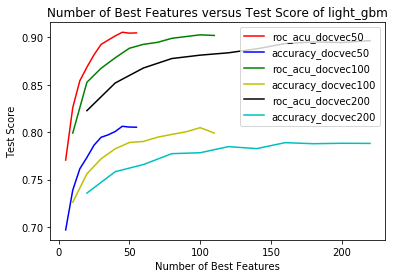

In [29]:
# Find the auc_roc value and accuracy value for different number 
# of best k features then plot the graph in LightGBM
choose_docvec50_gbm = choose_csv(docvec50, OneVsRestClassifier(LGBMClassifier(random_state = 42)), 
                                 'docvec50', 'light_gbm','r', 'b')
choose_docvec100_gbm = choose_csv(docvec100, OneVsRestClassifier(LGBMClassifier(random_state = 42)), 
                                  'docvec100', 'light_gbm','g', 'y')
choose_docvec200_gbm = choose_csv(docvec200, OneVsRestClassifier(LGBMClassifier(random_state = 42)), 
                                  'docvec200', 'light_gbm','k', 'c')

In [30]:
# Find the number of best k features and corrsponding dataset to use
dataset_gbm = suitable_dataset(choose_docvec50_gbm, choose_docvec100_gbm, choose_docvec200_gbm, docvec50, 
                               docvec100, docvec200)

# Create the new dataset according to the dataset selected
useful_df = pd.concat([meta.iloc[:, 4:7], dataset_gbm[0][0]], axis = 1)
real_test_gbm = pd.concat([meta_test.iloc[:, 4:7], docvec50_test], axis = 1)

# Split the whole dataset to training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(useful_df, label, test_size = 0.33, random_state = 42)

# Convert the training and testing dataset to the desired demension
# by the number of best k features 
mi = SelectKBest(score_func = mutual_info_classif, k = dataset_gbm[0][1])
x_train = pd.DataFrame(mi.fit_transform(x_train, y_train))
x_test = pd.DataFrame(mi.transform(x_test))
real_test_gbm = pd.DataFrame(mi.transform(real_test_gbm))

# Binarize training dataset's label in prepartion of scoring by roc_auc
y_train_binarize = label_binarize(y_train, classes = [1, 3, 5])

Text(0, 0.5, 'Test Score')

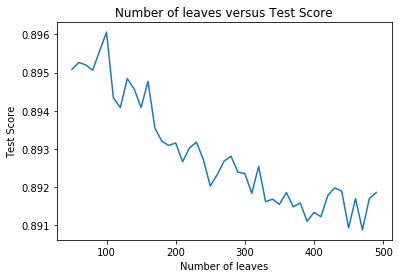

In [31]:
# Cursory search for number of leaves hyperparameter
num_leaves_score = []
for i in np.arange(50, 500, 10):
    cv_results = cross_validate(OneVsRestClassifier(LGBMClassifier(num_leaves = i, random_state = 42)), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    num_leaves_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph
plt.plot(np.arange(50, 500, 10), num_leaves_score)
plt.title(f'Number of leaves versus Test Score')
plt.xlabel('Number of leaves')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

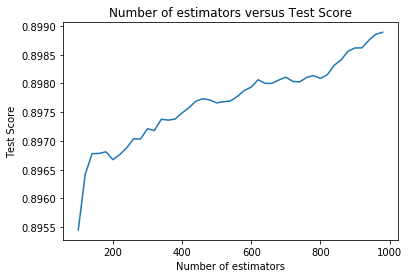

In [32]:
# Cursory search for number of estimators hyperparameter
n_estimators_score = []
for i in np.arange(100, 1000, 20):
    cv_results = cross_validate(OneVsRestClassifier(LGBMClassifier(n_estimators = i, random_state = 42)), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    n_estimators_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph
plt.plot(np.arange(100, 1000, 20), n_estimators_score)
plt.title(f'Number of estimators versus Test Score')
plt.xlabel('Number of estimators')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

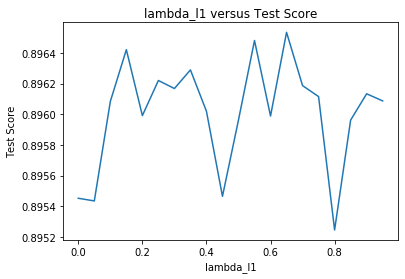

In [34]:
# Cursory search lambda_l1 hyperparameter
lambda_l1_score = []
for i in np.arange(0, 1, 0.05):
    cv_results = cross_validate(OneVsRestClassifier(LGBMClassifier(lambda_l1 = i, random_state = 42)), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    lambda_l1_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph
plt.plot(np.arange(0, 1, 0.05), lambda_l1_score)
plt.title(f'lambda_l1 versus Test Score')
plt.xlabel('lambda_l1')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

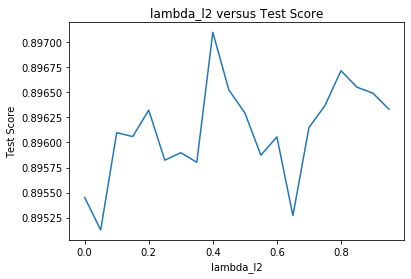

In [35]:
# Cursory search lambda_l2 hyperparameter
lambda_l2_score = []
for i in np.arange(0, 1, 0.05):
    cv_results = cross_validate(OneVsRestClassifier(LGBMClassifier(lambda_l2 = i, random_state = 42)), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    lambda_l2_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph
plt.plot(np.arange(0, 1, 0.05), lambda_l2_score)
plt.title(f'lambda_l2 versus Test Score')
plt.xlabel('lambda_l2')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

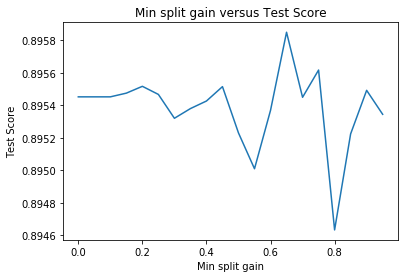

In [37]:
# Cursory search min split gain hyperparameter
min_split_gain_score = []
for i in np.arange(0, 1, 0.05):
    cv_results = cross_validate(OneVsRestClassifier(LGBMClassifier(min_split_gain = i, random_state = 42)), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    min_split_gain_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph
plt.plot(np.arange(0, 1, 0.05), min_split_gain_score)
plt.title(f'Min split gain versus Test Score')
plt.xlabel('Min split gain')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

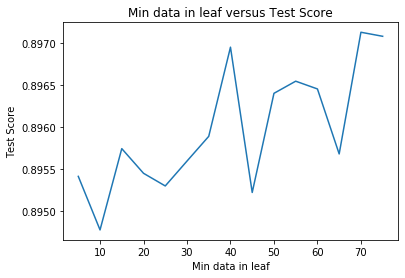

In [38]:
# Cursory search min data in leaf hyperparameter
min_data_in_leaf_score = []
for i in np.arange(5, 80, 5):
    cv_results = cross_validate(OneVsRestClassifier(LGBMClassifier(min_data_in_leaf = i, random_state = 42)), 
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    min_data_in_leaf_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph
plt.plot(np.arange(5, 80, 5), min_data_in_leaf_score)
plt.title(f'Min data in leaf versus Test Score')
plt.xlabel('Min data in leaf')
plt.ylabel('Test Score')

Text(0, 0.5, 'Test Score')

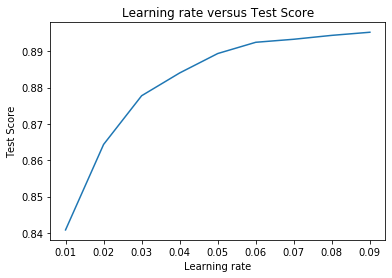

In [39]:
# Cursory search learning rate hyperparameter
learning_rate_score = []
for i in np.arange(0.01, 0.1, 0.01):
    cv_results = cross_validate(OneVsRestClassifier(LGBMClassifier(learning_rate = i, random_state = 42)),
                                x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
    learning_rate_score.append(sum(cv_results['test_score']) / len(cv_results))
    
# Plot the graph
plt.plot(np.arange(0.01, 0.1, 0.01), learning_rate_score)
plt.title(f'Learning rate versus Test Score')
plt.xlabel('Learning rate')
plt.ylabel('Test Score')

In [40]:
# Construct the function that needs to be maximize for light gbm
# Here the aim is to maximize the roc_auc score 
def lgb_func(num_leaves, n_estimators, max_depth,lambda_l1,lambda_l2, min_child_weight,min_split_gain, 
             min_data_in_leaf, learning_rate): 
    
    cv_results = cross_validate(OneVsRestClassifier(LGBMClassifier(
         num_leaves =  int(round(num_leaves)),
         n_estimators = int(round(n_estimators)), 
         max_depth = int(round(max_depth)),  
         lambda_l1 = lambda_l1,
         lambda_l2 = lambda_l2,                  
         min_child_weight = min_child_weight,
         min_split_gain = min_split_gain,                                    
         min_data_in_leaf = int(round(min_data_in_leaf)),
         learning_rate= learning_rate,        
         random_state = 42)), x_train, y_train_binarize, scoring = 'roc_auc', cv = 3)
        
    return sum(cv_results['test_score']) / len(cv_results)

In [41]:
# Find the global maximum of the target function by Bayesian Optimization
lgb_params = BayesianOptimization(lgb_func, {'num_leaves': (100, 300), 'n_estimators': (300, 800),
                                                'max_depth': (-1, 50), 'lambda_l1': (0, 0.5), 
                                             'lambda_l2': (0, 0.5), 'min_child_weight': (0, 10),
                                             'min_split_gain' : (0, 0.5), 'min_data_in_leaf': (10, 50),
                                             'learning_rate': (0.03, 0.06)}, random_state = 42)
lgb_params.maximize(n_iter = 20, init_points = 2)

|   iter    |  target   | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | min_sp... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8992   |  0.1873   |  0.4754   |  0.05196  |  29.53    |  1.56     |  16.24    |  0.02904  |  733.1    |  220.2    |
|  2        |  0.8982   |  0.354    |  0.01029  |  0.0591   |  41.45    |  2.123    |  17.27    |  0.0917   |  452.1    |  205.0    |
|  3        |  0.8987   |  0.1104   |  0.2719   |  0.05536  |  6.768    |  1.069    |  30.7     |  0.09433  |  797.1    |  100.9    |
|  4        |  0.8815   |  0.04385  |  0.1632   |  0.034    |  0.5917   |  8.915    |  35.35    |  0.1886   |  794.7    |  299.2    |
|  5        |  0.901    |  0.2036   |  0.1804   |  0.04768  |  49.35    |  8.747    |  49.25    |  0.1022   |  769.7    |  106.8    |
|  6        |  0.9001   |  0.1049   |  0.05343  |  0.03345  | 

In [42]:
# Find the best parameter
final_params_gbm = lgb_params.max

# Construct the basic light gbm model 
lightgbm_model = LGBMClassifier(
         num_leaves =  int(round(final_params_gbm['params']['num_leaves'])),
         n_estimators = int(round(final_params_gbm['params']['n_estimators'])), 
         max_depth = int(round(final_params_gbm['params']['max_depth'])),  
         lambda_l1 = final_params_gbm['params']['lambda_l1'],
         lambda_l2 = final_params_gbm['params']['lambda_l2'],                  
         min_child_weight = final_params_gbm['params']['min_child_weight'],
         min_split_gain = final_params_gbm['params']['min_split_gain'],                                
         min_data_in_leaf = int(round(final_params_gbm['params']['min_data_in_leaf'])),
         learning_rate= final_params_gbm['params']['learning_rate'],
         random_state = 42)

# Train the model according to the training dataset
lightgbm_model.fit(x_train, y_train)
# Predict and analysis the model 
model_pred = lightgbm_model.predict(x_test)
report_analysis = classification_report(y_test, model_pred, target_names = ['Rating = 1', 'Rating = 3', 'Rating = 5'])
print(report_analysis)
print(f'Exact accuracy for LightGBM is {lightgbm_model.score(x_test, y_test)}')

              precision    recall  f1-score   support

  Rating = 1       0.70      0.47      0.56       789
  Rating = 3       0.65      0.56      0.60      2060
  Rating = 5       0.86      0.94      0.90      6414

    accuracy                           0.81      9263
   macro avg       0.74      0.65      0.69      9263
weighted avg       0.80      0.81      0.80      9263

Exact accuracy for LightGBM is 0.8130195401057972


In [43]:
# Predict ratings for real testing set and convert to csv
model_pred_gbm = lightgbm_model.predict(real_test_gbm)
Instance_id = list(range(1, len(model_pred_gbm)+1))
lightgbm_pred = pd.DataFrame(data = {'Instance_id': Instance_id, 'rating': model_pred_gbm})
lightgbm_pred = lightgbm_pred.set_index(['Instance_id', 'rating'])
lightgbm_pred.to_csv('LightGBM.csv')